# Flu Shot Learning - Machine Learning Final Project

Having experimented with logistic regressions, CatBoost was experimented with to check if there were any gains available using it. The experiments were ran in a seperate jupyter notebook, due to catboost needing the categorical features specified, and in the first notebook column transformers were utilized for applying the preprocessing automatically. See more information [here](https://stackoverflow.com/questions/56742441/how-to-track-categorical-indices-for-catboost-with-sklearn-pipeline)

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.multioutput import MultiOutputClassifier

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

RANDOM_SEED = 1337


In [2]:
# Project data in google drive
#DATA_PATH = Path.cwd()/"drive"/"MyDrive"/"APC"/"data";
# Project data from repository
DATA_PATH = Path.cwd()/".."/"data";

features_train = pd.read_csv(
    DATA_PATH/"training_set_features.csv",
    index_col="respondent_id"
)

labels_train = pd.read_csv(
    DATA_PATH/"training_set_labels.csv",
    index_col="respondent_id"
)

np.testing.assert_array_equal(features_train.index.values, labels_train.index.values)

#### Preprocessing data:
For using the CatBoost classifier, preprocessing is much more straightforward as numeric values do not need to be scaled and categorical features don't require encoding. The only thing that is needed is to perform imputation for filling the missing values.

In [3]:
features_proc = features_train.fillna(value=-9999)

X_train, X_eval, y_train, y_eval = train_test_split(
    features_proc,
    labels_train,
    test_size=0.25, # 25% of data entries will be used for validation
    shuffle=True,
    stratify=labels_train,
    random_state=RANDOM_SEED
)

#### Preliminary model training
Again, we'll first test using only 75% of the available training data

In [6]:
cat_feat = features_train.columns[features_train.dtypes == 'object'].values
classifier=CatBoostClassifier(loss_function='Logloss', cat_features=cat_feat)

model = MultiOutputClassifier(
    estimator=classifier
)

model.fit(X_train, y_train)
preds = model.predict_proba(X_eval)
""" model.fit(X_train, y_train['h1n1_vaccine'])
preds_h1n1 = model.predict_proba(X_eval)
model.fit(X_train, y_train['seasonal_vaccine'])
preds_seasonal = model.predict_proba(X_eval) """

Learning rate set to 0.037047
0:	learn: 0.6644967	total: 19.8ms	remaining: 19.7s
1:	learn: 0.6383177	total: 34.2ms	remaining: 17.1s
2:	learn: 0.6156775	total: 50.4ms	remaining: 16.8s
3:	learn: 0.5951332	total: 66.8ms	remaining: 16.6s
4:	learn: 0.5747384	total: 80.1ms	remaining: 15.9s
5:	learn: 0.5566677	total: 95.5ms	remaining: 15.8s
6:	learn: 0.5404575	total: 111ms	remaining: 15.7s
7:	learn: 0.5253287	total: 126ms	remaining: 15.6s
8:	learn: 0.5123303	total: 141ms	remaining: 15.5s
9:	learn: 0.4999012	total: 156ms	remaining: 15.4s
10:	learn: 0.4892722	total: 170ms	remaining: 15.3s
11:	learn: 0.4788895	total: 184ms	remaining: 15.1s
12:	learn: 0.4705680	total: 197ms	remaining: 15s
13:	learn: 0.4622421	total: 212ms	remaining: 14.9s
14:	learn: 0.4542915	total: 227ms	remaining: 14.9s
15:	learn: 0.4470267	total: 243ms	remaining: 15s
16:	learn: 0.4402391	total: 258ms	remaining: 14.9s
17:	learn: 0.4343774	total: 272ms	remaining: 14.8s
18:	learn: 0.4289392	total: 285ms	remaining: 14.7s
19:	learn

" model.fit(X_train, y_train['h1n1_vaccine'])\npreds_h1n1 = model.predict_proba(X_eval)\nmodel.fit(X_train, y_train['seasonal_vaccine'])\npreds_seasonal = model.predict_proba(X_eval) "

In [8]:
y_preds = pd.DataFrame({
    "h1n1_vaccine": preds[0][:, 1],
    "seasonal_vaccine": preds[1][:, 1],
    },
    index = y_eval.index
)
y_preds.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
8004,0.048756,0.849311
20429,0.447749,0.739545
6634,0.004377,0.009647
9580,0.979243,0.960524
20754,0.172430,0.530861


#### Performance metrics

0.8690668059879585


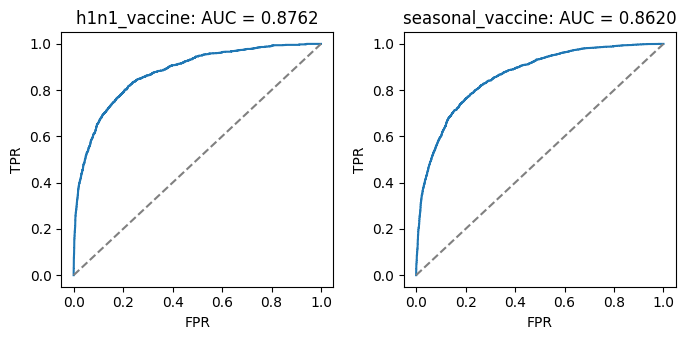

In [10]:
def plot_roc(y_true, y_score, label_name, ax : plt.Axes):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}")

fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(y_eval['h1n1_vaccine'], y_preds['h1n1_vaccine'], 'h1n1_vaccine', ax=ax[0])
plot_roc(y_eval['seasonal_vaccine'], y_preds['seasonal_vaccine'], 'seasonal_vaccine', ax=ax[1])
fig.tight_layout()

# Final score,
print(roc_auc_score(y_eval, y_preds))

#### Generate final submission

In [11]:
from os import makedirs

test_features = pd.read_csv(DATA_PATH / "test_set_features.csv", index_col="respondent_id")
test_features = test_features.fillna(-9999) #  preprocess these also

# Run the competition's test set to generate predictions
model.fit(features_proc, labels_train)
test_result = model.predict_proba(test_features)

Learning rate set to 0.041889
0:	learn: 0.6601647	total: 20.7ms	remaining: 20.7s
1:	learn: 0.6299215	total: 41.5ms	remaining: 20.7s
2:	learn: 0.6028907	total: 59.8ms	remaining: 19.9s
3:	learn: 0.5791901	total: 75.2ms	remaining: 18.7s
4:	learn: 0.5578652	total: 92.1ms	remaining: 18.3s
5:	learn: 0.5390895	total: 109ms	remaining: 18s
6:	learn: 0.5222404	total: 125ms	remaining: 17.7s
7:	learn: 0.5068955	total: 140ms	remaining: 17.4s
8:	learn: 0.4934581	total: 159ms	remaining: 17.5s
9:	learn: 0.4808343	total: 177ms	remaining: 17.5s
10:	learn: 0.4695243	total: 193ms	remaining: 17.3s
11:	learn: 0.4597252	total: 211ms	remaining: 17.4s
12:	learn: 0.4502612	total: 227ms	remaining: 17.3s
13:	learn: 0.4427386	total: 244ms	remaining: 17.2s
14:	learn: 0.4353187	total: 288ms	remaining: 18.9s
15:	learn: 0.4287526	total: 311ms	remaining: 19.1s
16:	learn: 0.4228395	total: 333ms	remaining: 19.3s
17:	learn: 0.4173729	total: 351ms	remaining: 19.2s
18:	learn: 0.4123915	total: 370ms	remaining: 19.1s
19:	lear

In [12]:
submission = pd.read_csv(DATA_PATH / "submission_format.csv", index_col = "respondent_id")
# Verify that the columns are in the right order
np.testing.assert_array_equal(test_features.index.values,
    submission.index.values)

# Select the probabilities a person has taken each vaccine
submission["h1n1_vaccine"] = test_result[0][:, 1]
submission["seasonal_vaccine"] = test_result[1][:, 1]

makedirs(Path.cwd().parent / "out", exist_ok=True); # create if non-existent
submission.to_csv(Path.cwd().parent / "out" / "cat_submission.csv", index=True)